# Peer-graded Assignment: Segmenting and Clustering Neighborhoods in Toronto - Ibrahim Volpi

#### Let's proceed to install and import all needed packages:

In [1]:
#!pip install geocoder
#!pip install lxml
#!pip install beautifulsoup4
#!pip install folium

In [2]:
import random # library for random number generation
import numpy as np # library for vectorized computation
import pandas as pd # library to process data as dataframes
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import numpy as np
from itertools import chain
from sklearn import metrics
import geocoder # import geocoder
from bs4 import BeautifulSoup 
import folium 
import matplotlib.pyplot as plt

#### The below code sets the location of the wikipedia web page and scrap the section where the information for the table is located

In [3]:
website_url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text #request to get the html as text

In [4]:
soup = BeautifulSoup(website_url,'lxml')
My_table = soup.find('table',{'class':'wikitable sortable'}) #getting the section of the code related to the table

#### In this first part of Data Pre-processing, let's get the data from the code scrapped above cleaned by runing some "for/While" instances to get the data cleaned as much as possible from alien characters and blank spaces.

In [5]:
Vector=[]
test2=My_table.find_all("td")

n=0
while n<len(test2):
    Vector=Vector + [test2[n]]                        #getting just the part that has the table content
    n=n+1

i=0
while i<len(Vector):
    Vector[i]=str(Vector[i])                                             
    i=i+1
t=0
Vector_G=[]
while t<len(Vector):
    Vector_G=Vector_G + [[Vector[t],Vector[t+1],Vector[t+2]]]              #grouping into three coloumns
    n=n+1
    t=t+3

for i in Vector_G:
    for t in range (0,3):
        i[t]=i[t].replace("<td>",'')
        i[t]=i[t].replace("</td>",'')                                     #eliminating extra char. not needed
        i[t]=i[t].replace("\n",'')
        i[t]=i[t].replace('<a href="/wiki/','')      
        i[t]=i[t].replace('</a>','')
        i[t]=i[t].replace('>',' ')

x=0
while x<len(Vector_G):
    Vector_G[x][1]=Vector_G[x][1].split('"',-1)[-1]
    Vector_G[x][2]=Vector_G[x][2].split('"',-1)[-1]                         #recovering the Borough and Neighborhoods        
    x=x+1

x=0
i=0
while x<len(Vector_G):
    while i<3:
        Vector_G[x][i]=Vector_G[x][i].strip()                         #deleting blank spaces before and after each value
        i=i+1
    i=0
    x=x+1   

#### Once the data is being prepared, lets create a Pandas DataFrame and make sure to fulfill the requirements as per the assignment: 

-  a) rows with Borough as "Not Assigned" will be dropped.
- b) rows with Neigbourhood as "Not assigned" will be assigned with the Borough name.

In [6]:
Df=pd.DataFrame(Vector_G)
Df.columns = ['PostalCode', 'Borough', 'Neighborhood']              #setting the headers
Df2=Df.copy()
Df = Df[Df.Borough != 'Not assigned']                               #dropping the rows with Borough='Not assigned'
lt=Df.values.tolist()                                 #converting to list to add the borough as neigh. when not assigned
for i in lt:
    if i[2]=='Not assigned':
        i[2]=i[1]
Df=pd.DataFrame(lt)                                            #converting to DataFrame again, setting headers again
Df.columns = ['PostalCode', 'Borough', 'Neighborhood']           

#### Data sharing the same Postal Code will be merged in one row.    

In [7]:
aggregation_functions = {'PostalCode': 'first', 'Borough': 'first', 'Neighborhood': ", ".join}
Df_group = Df.groupby(Df['PostalCode']).aggregate(aggregation_functions)
Df=Df_group.reset_index(drop='true')               #combining the coloumns with same post code, reseting index afterwards

In [8]:
Df[0:10]                                        #showing the first ten rows

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


In [9]:
Df.shape                       #informing the shape as per requested.

(103, 3)

#### Up to this point would be the first part of the assignment
#### Let's now recover the Latitud and Longitud for each Postal Code using the Geocoder Package

In [10]:
lat_lng_coords = []
code=Df["PostalCode"].tolist()                                           #Creates a list with the coord. and the Codes

for i in code:
    g = geocoder.arcgis('{0}, Toronto, Ontario'.format(i))
    lat_lng_coords = lat_lng_coords + [[i] + g.latlng]
    
  

#### DataFrame created using the coordinates 

In [11]:
Geocode=pd.DataFrame(lat_lng_coords)    #Creates a DataFrame from the previous list
Geocode.columns=['PostalCode', 'Latitude','Longitude']  #Define columns

In [12]:
Geocode.head()

,PostalCode,Latitude,Longitude
0,M1B,43.811525,-79.195517
1,M1C,43.785665,-79.158725
2,M1E,43.765815,-79.175193
3,M1G,43.768369,-79.217590
4,M1H,43.769688,-79.239440


#### New DataFrame thats concatenate the new information with our previous DataFrame

In [13]:
Df=pd.concat([Df, Geocode['Latitude'], Geocode['Longitude']], axis=1) #concatenate the tables
Df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.811525,-79.195517
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.785665,-79.158725
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.765815,-79.175193
3,M1G,Scarborough,Woburn,43.768369,-79.217590
4,M1H,Scarborough,Cedarbrae,43.769688,-79.239440


#### Folium Map with the location of each Postal code superimposed on top.

In [14]:
# create map of Toronto using latitude and longitude values
map_Toronto = folium.Map(location=[43.653226,-79.383184], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(Df['Latitude'], Df['Longitude'], Df['Borough'], Df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

#### As per the assignment request, filter by data that has the word "Toronto" included on its Borough's name. 

In [15]:
Df_Toronto=Df[Df['Borough'].str.contains("Toronto")==True] #Creating a new DF with on that has the word "Toronto" included on its Borough's name.ly the data with a Borough that contains "Toronto" in its name
Df_Toronto=Df_Toronto.reset_index(drop='true') 
Df_Toronto = Df_Toronto.drop("PostalCode", axis=1)

#### Average Location and  a new folium map with the "Toronto" Data selected

In [16]:
Lat_Tor=Df_Toronto["Latitude"].mean()
Long_Tor=Df_Toronto["Longitude"].mean()

#### Folium Map showing the location of the different data entries for Postal Codes that has the word "Toronto" included on its Borough's name

In [17]:
# create map of  Boroughs in Toronto using latitude and longitude values
map_Toronto_borough = folium.Map(location=[Lat_Tor,Long_Tor], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(Df_Toronto['Latitude'], Df_Toronto['Longitude'], Df_Toronto['Borough'], Df_Toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto_borough) 
    
map_Toronto_borough

#### Creating a stance for Foursquare to explore Nearby Venues and run this through all the different postal codes.

In [37]:
# @hidden_cell
CLIENT_ID = 'HIDE' # your Foursquare ID
CLIENT_SECRET = 'HIDE' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: HIDE
CLIENT_SECRET:HIDE


In [19]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [20]:
Toronto_venues = getNearbyVenues(names=Df_Toronto['Neighborhood'],
                                   latitudes=Df_Toronto['Latitude'],
                                   longitudes=Df_Toronto['Longitude']
                                  )

The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront, Regent Park
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
The Annex, North Midtown, Yorkville
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, Exhibition Place, Parkdale Village
High Park, The 

#### Unique categories and drop of the data with less than 10 venues explored. 

In [21]:
counts = Toronto_venues['Neighborhood'].value_counts()
Toronto_Venues = Toronto_venues[~Toronto_venues['Neighborhood'].isin(counts[counts < 10].index)]
Toronto_venues=Toronto_venues.reset_index(drop='true')

In [22]:
print('There are {} uniques categories.'.format(len(Toronto_venues['Venue Category'].unique())))

There are 220 uniques categories.


#### One hot encoding of the Venue Categories

In [23]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Neighborhood'] = Toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_onehot.head()

,Yoga Studio,Afghan Restaurant,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,...,Toy / Game Store,Trail,Train Station,Tram Station,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
Toronto_onehot.shape

(1773, 220)

#### Mean and group by of data. 

In [25]:
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()
Toronto_grouped

,Neighborhood,Yoga Studio,Afghan Restaurant,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Toy / Game Store,Trail,Train Station,Tram Station,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint
0,"Adelaide, King, Richmond",0.000000,0.000000,0.030000,0.00000,0.010000,0.00,0.000000,0.030000,0.000000,...,0.000000,0.000000,0.00,0.00000,0.010000,0.000000,0.000000,0.000000,0.010000,0.000000
1,Berczy Park,0.000000,0.000000,0.000000,0.00000,0.015625,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.00000,0.015625,0.000000,0.000000,0.000000,0.000000,0.000000
2,"Brockton, Exhibition Place, Parkdale Village",0.000000,0.000000,0.000000,0.00000,0.014286,0.00,0.014286,0.000000,0.000000,...,0.000000,0.000000,0.00,0.00000,0.028571,0.000000,0.000000,0.014286,0.000000,0.000000
3,Business Reply Mail Processing Centre 969 Eastern,0.000000,0.000000,0.030000,0.00000,0.010000,0.00,0.010000,0.020000,0.000000,...,0.000000,0.000000,0.00,0.00000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",0.014706,0.000000,0.000000,0.00000,0.000000,0.00,0.000000,0.014706,0.000000,...,0.000000,0.000000,0.00,0.00000,0.014706,0.014706,0.000000,0.000000,0.000000,0.000000
5,"Cabbagetown, St. James Town",0.000000,0.000000,0.000000,0.00000,0.000000,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Central Bay Street,0.000000,0.000000,0.010000,0.00000,0.010000,0.01,0.000000,0.000000,0.000000,...,0.010000,0.000000,0.00,0.00000,0.000000,0.000000,0.010000,0.010000,0.010000,0.000000
7,"Chinatown, Grange Park, Kensington Market",0.000000,0.000000,0.000000,0.00000,0.021739,0.00,0.021739,0.000000,0.000000,...,0.010870,0.000000,0.00,0.00000,0.054348,0.000000,0.000000,0.043478,0.010870,0.000000
8,Christie,0.000000,0.000000,0.000000,0.00000,0.000000,0.00,0.000000,0.000000,0.090909,...,0.000000,0.000000,0.00,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Church and Wellesley,0.012346,0.012346,0.012346,0.00000,0.000000,0.00,0.012346,0.000000,0.000000,...,0.000000,0.000000,0.00,0.00000,0.000000,0.000000,0.012346,0.000000,0.000000,0.012346


In [26]:
Toronto_grouped.shape

(38, 220)

#### Analysis of the top 10 venues per location. 

In [27]:
num_top_venues = 10

for hood in Toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Toronto_grouped[Toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
                 venue  freq
0          Coffee Shop  0.08
1                 Café  0.06
2                Hotel  0.05
3           Steakhouse  0.04
4  American Restaurant  0.03
5         Burger Joint  0.03
6       Breakfast Spot  0.03
7           Restaurant  0.03
8            Gastropub  0.03
9                  Bar  0.03


----Berczy Park----
                venue  freq
0         Coffee Shop  0.08
1          Restaurant  0.05
2        Cocktail Bar  0.05
3          Steakhouse  0.03
4              Bakery  0.03
5         Cheese Shop  0.03
6  Seafood Restaurant  0.03
7            Beer Bar  0.03
8      Breakfast Spot  0.03
9      Farmers Market  0.03


----Brockton, Exhibition Place, Parkdale Village----
                           venue  freq
0                    Coffee Shop  0.09
1                     Restaurant  0.06
2                           Café  0.06
3         Furniture / Home Store  0.06
4                 Sandwich Place  0.04
5                            

                             venue  freq
0                   Sandwich Place   0.5
1                             Park   0.5
2                      Yoga Studio   0.0
3                      Men's Store   0.0
4               Mexican Restaurant   0.0
5        Middle Eastern Restaurant   0.0
6               Miscellaneous Shop   0.0
7       Modern European Restaurant   0.0
8  Molecular Gastronomy Restaurant   0.0
9              Monument / Landmark   0.0


----Lawrence Park----
                        venue  freq
0                    Bus Line  0.33
1                 Swim School  0.33
2                      Lawyer  0.33
3                 Music Store  0.00
4    Mediterranean Restaurant  0.00
5                 Men's Store  0.00
6          Mexican Restaurant  0.00
7   Middle Eastern Restaurant  0.00
8          Miscellaneous Shop  0.00
9  Modern European Restaurant  0.00


----Little Portugal, Trinity----
                     venue  freq
0              Coffee Shop  0.06
1                      Bar  

#### Creation of the merged DataFrame before proceeding with the clustering.

In [28]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [29]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Toronto_grouped['Neighborhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted[0:10]
Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)

#### Elbow Method to find out optimized number of cluster for K-means. 

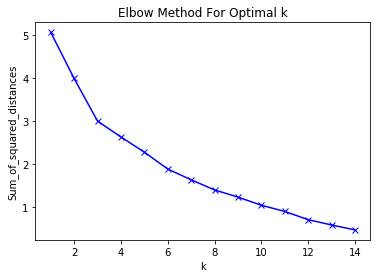

In [30]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(Toronto_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

#### K-Means Fit and compute of Silhouette Score ----> 0.5492

In [31]:
# set number of clusters
kclusters =3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe

metrics.silhouette_score(Toronto_grouped_clustering, kmeans.labels_, metric="euclidean")

0.5491781649960007

#### DataFrame with the cluster column added - Toronto_merged

In [32]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_) 

Toronto_merged = Df_Toronto[:]
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Toronto_merged = Toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood', how = 'right')


#### Creation of a Folium Map to Ilustrate the different clusters

In [33]:
# create map
map_clusters = folium.Map(location=[Lat_Tor,Long_Tor], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighborhood'], Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Analysis of Cluster 0 -- Hospitality / Food Store / Eating out Cluster

- Main cluster that groupped most of the data
- Similar services in the top positions: Coffee Shops and Restaurants. 
- Services related to the food industry
                       

In [34]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 0, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,The Beaches,Health Food Store,Trail,Pub,Dumpling Restaurant,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant
1,"The Danforth West, Riverdale",Park,Bus Line,Grocery Store,Discount Store,Wings Joint,Elementary School,Flea Market,Fish Market,Fish & Chips Shop,Fast Food Restaurant
2,"The Beaches West, India Bazaar",Park,Pizza Place,Burger Joint,Ice Cream Shop,Fish & Chips Shop,Burrito Place,Sandwich Place,Steakhouse,Sushi Restaurant,Italian Restaurant
3,Studio District,Diner,Café,Italian Restaurant,Arts & Crafts Store,Brewery,Bar,Pizza Place,Coffee Shop,Sushi Restaurant,Sandwich Place
4,Lawrence Park,Bus Line,Lawyer,Swim School,Wings Joint,Elementary School,Flea Market,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
5,Davisville North,Clothing Store,Park,American Restaurant,Food & Drink Shop,Hotel,Bus Line,Gym,Breakfast Spot,Farmers Market,Event Space
6,North Toronto West,Park,Gym Pool,Playground,Garden,Wings Joint,Eastern European Restaurant,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm
7,Davisville,Dessert Shop,Café,Sandwich Place,Italian Restaurant,Coffee Shop,Pizza Place,Indoor Play Area,Diner,Seafood Restaurant,Restaurant
8,"Moore Park, Summerhill East",Gym,Convenience Store,Summer Camp,Trail,Restaurant,Deli / Bodega,Electronics Store,Fish Market,Fish & Chips Shop,Fast Food Restaurant
9,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",Light Rail Station,Coffee Shop,Liquor Store,Supermarket,Wings Joint,Elementary School,Flea Market,Fish Market,Fish & Chips Shop,Fast Food Restaurant


#### Analysis of Cluster 1 -- Parks and Markets 

- Two main locations 
- Similar services in the top positions: Parks and different Markets. 

In [35]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 1, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,"Forest Hill North, Forest Hill West",Park,Wings Joint,Eastern European Restaurant,Flea Market,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant
34,"High Park, The Junction South",Park,Sandwich Place,Wings Joint,Eastern European Restaurant,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant


#### Analysis of Cluster 2 -- IT and electronic stores 

- Only one location
- Similar services in the top positions: Electronic stores and IT

In [36]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 2, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Roselawn,IT Services,Wings Joint,Electronics Store,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm


#### Conclusions:

- Mainly in the City of Toronto, the Boroughs that include the word 'Toronto' on its name are areas of high density on the food offer including several coffee shops and restaurants oriented to different cuisines.

- There are two main locations oriented to the leisure in open spaces with plenty options in terms of different type of Markets and Parks.

- Roselawn seem to be discriminated separated as a location for mainly IT and electronic stores or as an outlier, the low amount of data is not conclusive